In [39]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_series, load_data_preprocessing
from sklearn.model_selection import train_test_split


In [66]:
series = load_data_preprocessing('KTG')
series = series['harga']

In [87]:
time = np.arange(series.shape[0], dtype="float32")

# Define the split time
split_time = 700

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]



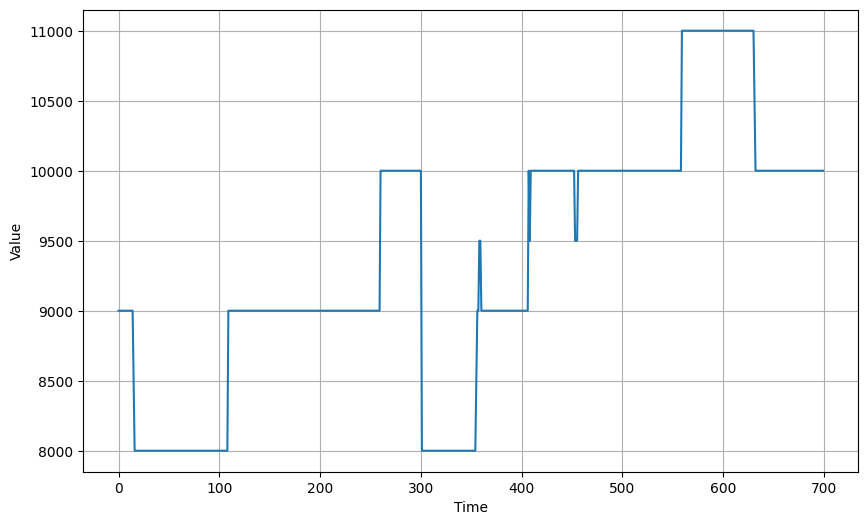

In [73]:
# Plot the train set
plot_series(time_train, x_train)

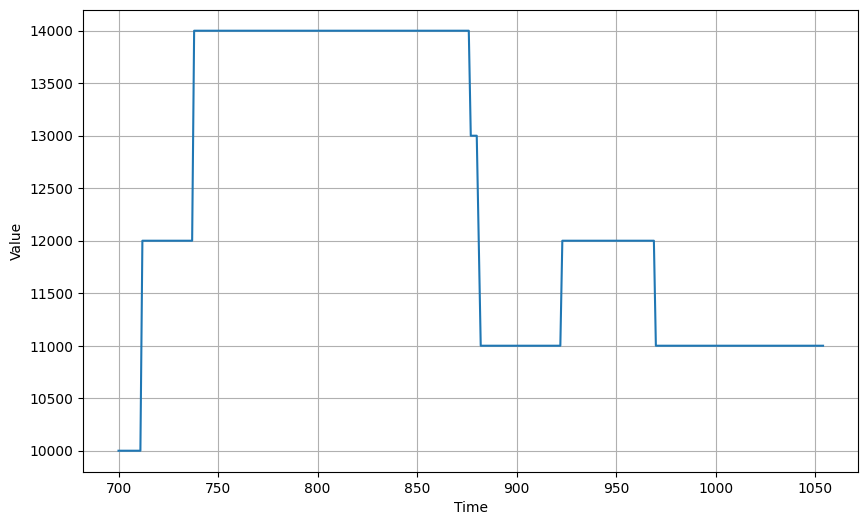

In [88]:
# Plot the validation set
plot_series(time_valid, x_valid)

In [94]:
# Generate the naive forecast
naive_forecast = series[split_time - 1:-1]

# Define time step
time_step = 100

# Print values
print(x_valid.array[100])
print(f'ground truth at time step {time_step}: {x_valid.array[100]}')
print(f'prediction at time step {time_step + 1}: {naive_forecast.array[time_step + 1]}')

14000.0
ground truth at time step 100: 14000.0
prediction at time step 101: 14000.0


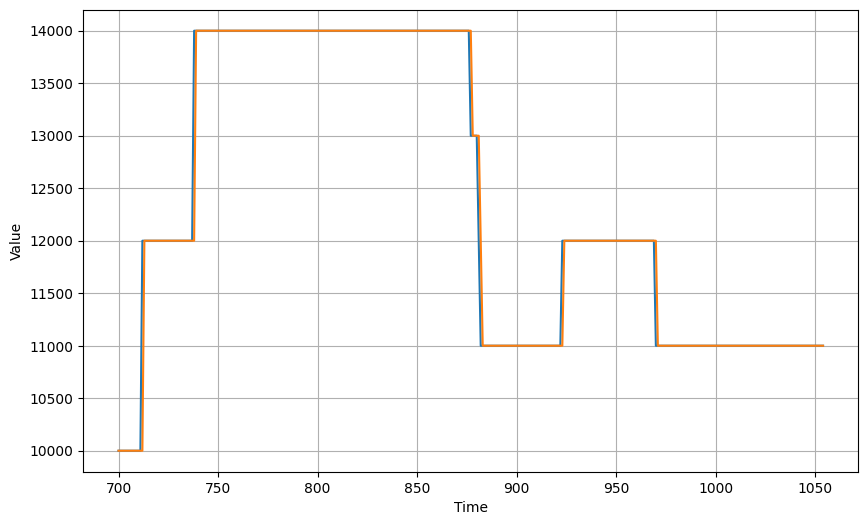

In [95]:
# Plot the results
plot_series(time_valid, (x_valid, naive_forecast))

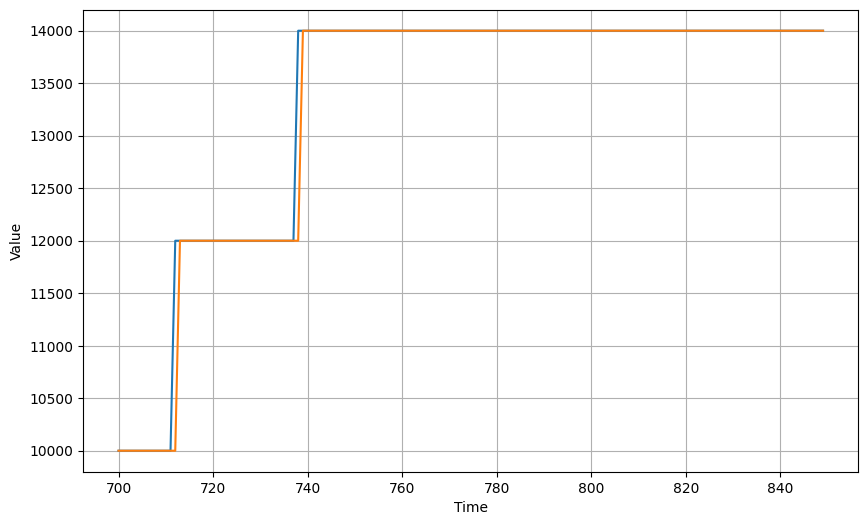

In [96]:
# Zooming in
plot_series(time_valid, (x_valid, naive_forecast), start=0, end=150)

### Computing Metrics

Now you will compute the [mean squared error](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/mean_squared_error) and the [mean absolute error](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/mean_absolute_error) between the forecasts and the predictions in the validation period. These are available via the [`tf.keras.metrics`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/) API. 

In [97]:
print(tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

36619.718309859156
25.35211267605634


## Moving Average

One technique you can use is to do a moving average. This sums up a series of time steps and the average will be the prediction for the next time step. For example, the average of the measurements at time steps 1 to 10 will be the forecast for time step 11, then the average for time steps 2 to 11 will be the forecast for time step 12, and so on.

The function below does the moving average for the entire `series`. It takes a `window_size` argument to indicate the number of time steps to consider when computing the mean.

In [98]:
def moving_average_forecast(series, window_size):
    """Generates a moving average forecast

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to compute the average for

    Returns:
      forecast (array of float) - the moving average forecast
    """

    # Initialize a list
    forecast = []
    
    # Compute the moving average based on the window size
    for time in range(len(series) - window_size):
      forecast.append(series[time:time + window_size].mean())
    
    # Convert to a numpy array
    forecast = np.array(forecast)

    return forecast

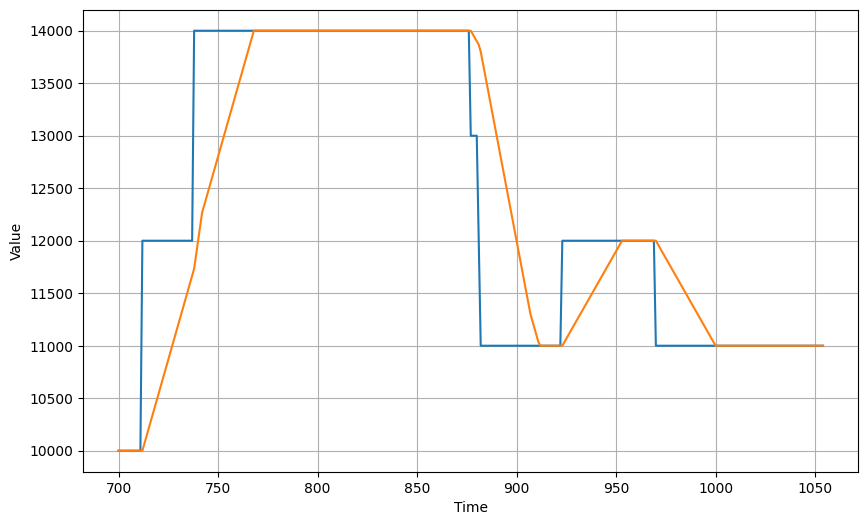

In [99]:
# Generate the moving average forecast
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

# Plot the results
plot_series(time_valid, (x_valid, moving_avg))

In [100]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

540610.3286384977
392.9577464788732


## Differencing

Since the seasonality period is 365 days, you will subtract the value at time *t* – 365 from the value at time *t*. That is done with the code below. 

In addition, you will need to align the result with the `time` array. Since you can only do time differencing for `t >= 365`, you will need to truncate the first 365 time steps of the `time` array.

You can plot the result to visualize the values.

ValueError: x and y must have same first dimension, but have shapes (690,) and (1055,)

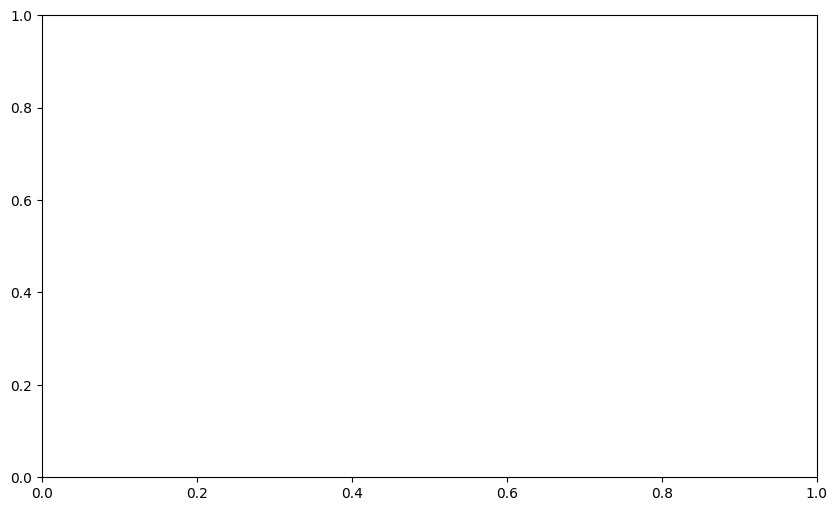

In [101]:
# Subtract the values at t-365 from original series
diff_series = (series[365:] - series[:-365])

# Truncate the first 365 time steps
diff_time = time[365:]

# Plot the results
plot_series(diff_time, diff_series)

ValueError: x and y must have same first dimension, but have shapes (355,) and (720,)

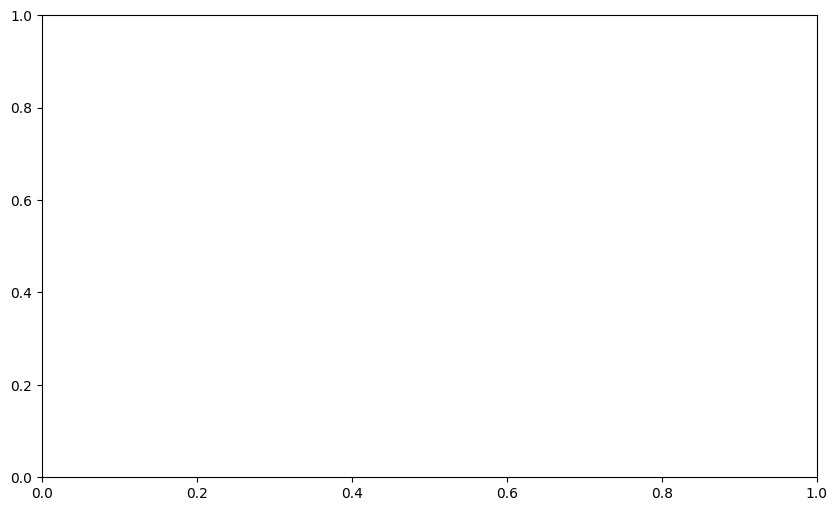

In [102]:
# Generate moving average from the time differenced dataset
diff_moving_avg = moving_average_forecast(diff_series, 30)

# Slice the prediction points that corresponds to the validation set time steps
diff_moving_avg = diff_moving_avg[split_time - 365 - 30:]

# Slice the ground truth points that corresponds to the validation set time steps
diff_series = diff_series[split_time - 365:]

# Plot the results
plot_series(time_valid, (diff_series, diff_moving_avg))